In [1]:
# import libraries
%matplotlib inline
import numpy as np
#import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.spatial
import scipy.stats

In [2]:
city = 'Baltimore'
urbanID = 'USW00093784' # import sci center 
#ruralID = 'USW00093721' # import bwi as rural 
ruralID = 'USC00185934' # import actual rural station

urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                 as_dataframe=True, update = False)
ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                 as_dataframe=True, update = False)
#if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 
######
###### Import data
######
rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 

# extract summertime data 
rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

# clean data: eliminate min temperatures below 4 or above 35
rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

#calculate UHI
UHI = urban_summer - rural_summer

# for year in year, plot heatwave data 

/Users/annascott2/git/ulmo-gottscott/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/annascott2/git/ulmo-gottscott/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/annascott2/git/ulmo-gottscott/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[column_name][dates] =

In [6]:
!pwd

/Users/annascott2/git/heat


In [8]:
test = pd.DataFrame()
test['tmin_urban_%s'%urbanID] = urban_summer
test['tmin_rural_%s'%ruralID] = rural_summer
test.to_csv('BaltimoreTminJJA2000_2015.csv')

In [9]:
test.head()

tmin_urban_USW00093784  tmin_rural_USC00185934
month_period                                                
1998-06-23                      23.3                    20.6
1998-06-24                      23.3                    19.4
1998-06-25                      25.0                    18.9
1998-06-26                      26.1                    22.2
1998-06-27                      26.1                    22.2

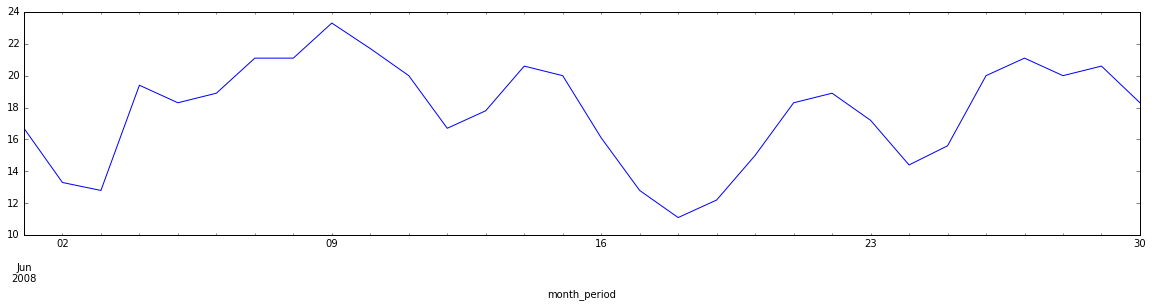

In [46]:
plt.figure(figsize= [20,4])
rural_summer[(rural_summer.index.year ==2008) & (rural_summer.index.month ==6) ].plot()

In [61]:
# perform total least squares regression
from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
linear = Model(f)
x = rural_summer
y = urban_summer
x = x[y.dropna().index]
y = y[x.index]
ind = ~np.isnan(y) & ~np.isnan(x)
linreg = scipy.stats.linregress(x[ind], y[ind])
mydata = Data(x[ind], y[ind])
myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
myoutput = myodr.run()
myoutput.pprint()

Beta: [ 0.84588531  7.41106774]
Beta Std Error: [ 0.01391511  0.24069205]
Beta Covariance: [[  9.75930291e-05  -1.65879581e-03]
 [ -1.65879581e-03   2.91990770e-02]]
Residual Variance: 1.98405796648
Inverse Condition #: 0.0912849532745
Reason(s) for Halting:
  Sum of squares convergence


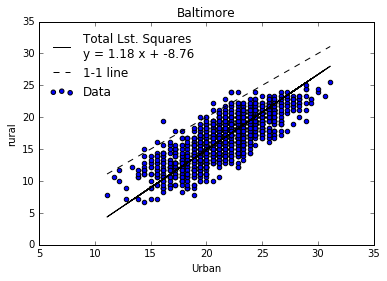

In [73]:
linear = Model(f)
y = rural_summer
x = urban_summer
x = x[y.dropna().index]
y = y[x.index]
ind = ~np.isnan(y) & ~np.isnan(x)
linreg = scipy.stats.linregress(x[ind], y[ind])
mydata = Data(x[ind], y[ind])
myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
myoutput = myodr.run()
#myoutput.pprint()
plt.plot(x, f(myoutput.beta, x), 'k')
plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
plt.scatter(x,y)
plt.xlabel('Urban')
plt.ylabel('rural')
plt.legend(['Total Lst. Squares \ny = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
            '1-1 line', 'Data'], loc=2, frameon =False)
plt.title('Baltimore')


In [76]:
# pull out the 1st principle component to do heatwave analysis

#import numpy as np
from sklearn.decomposition import PCA

x = rural_summer
y = urban_summer
x = x[y.dropna().index]
y = y[x.index]
ind = ~np.isnan(y) & ~np.isnan(x)

X = np.array([x[ind].values,y[ind].values])
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [84]:
U, s, Vh  = scipy.linalg.svd(X.T)

In [85]:
U.shape,  s.shape, Vh.shape

((1708, 1708), (2,), (2, 2))

In [88]:
X.shape

(2, 1708)

In [104]:
u, s, v = np.linalg.svd(X-X.mean(), full_matrices=False)
plt.plot(v[0])

In [71]:
plt.legend?

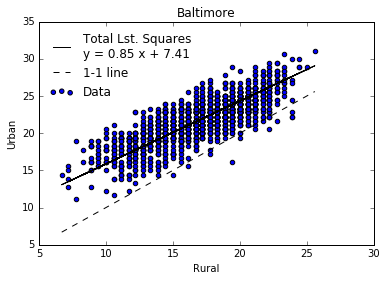

In [72]:
plt.plot(x, f(myoutput.beta, x), 'k')
plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
plt.scatter(x,y)
plt.xlabel('Rural')
plt.ylabel('Urban')
plt.legend(['Total Lst. Squares \ny = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
            '1-1 line', 'Data'], loc=2, frameon =False)
plt.title('Baltimore')

#ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(text_x_loc, text_y_loc), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')


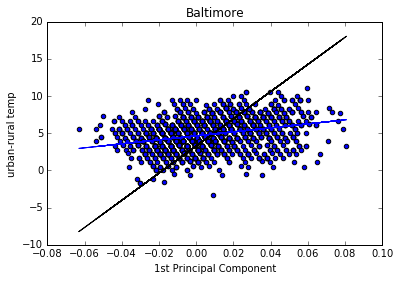

In [139]:
# now look at tu-tr versus t(d), 1st principle component
# pull out the 1st principle component to do heatwave analysis
x = rural_summer
y = urban_summer
x = x[y.dropna().index]
y = y[x.index]
ind = ~np.isnan(y) & ~np.isnan(x)

X = np.array([x[ind].values,y[ind].values])
u, s, v = np.linalg.svd(X-X.mean(), full_matrices=False)
# plot T(d) versus urban-rural
plt.scatter(v[0],y[ind]- x[ind])
#plt.plot(linreg.slope*v[0] +linreg.intercept, '-k')
# compute total least squres regression of slope
linreg = scipy.stats.linregress(v[0],y[ind]- x[ind])
mydata = Data(v[0],y[ind]- x[ind])
myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
myoutput = myodr.run()
plt.plot(v[0], f(myoutput.beta, v[0]), 'k')
plt.plot(v[0], linreg[0]*v[0] + linreg[1], 'blue')


plt.xlabel('1st Principal Component')
plt.ylabel('urban-rural temp')
plt.title('Baltimore')

In [202]:
final_num_hw = 10#50

hw_ids = np.argsort(v[0])[(-1*final_num_hw):]
hw_dates = rural_tmin.iloc[hw_ids].index

In [203]:
hw_dates

PeriodIndex(['1988-12-07', '1989-10-12', '1989-05-08', '1990-02-15',
             '1988-10-25', '1991-08-15', '1988-11-05', '1990-11-08',
             '1992-08-20', '1989-05-06'],
            dtype='period[D]', name=u'month_period', freq='D')

In [200]:
np.sort(v[0])[-10:]

array([ 0.06469668,  0.06510438,  0.06675972,  0.07065564,  0.07158393,
        0.07321556,  0.07620689,  0.07735972,  0.07919822,  0.08080615])

In [205]:
final_num_hw = 10#50
hw_ids = np.argsort(v[0])[(-1*final_num_hw):]
hw_dates = rural_summer.iloc[hw_ids].index
rural_tmin[hw_dates]

month_period
1991-06-06     8.9
1994-07-09    22.8
1992-08-05    13.3
1995-08-12    18.3
1990-07-25    16.1
2001-08-06    20.6
1990-08-05    18.9
1998-08-02    11.1
2005-08-09    18.9
1992-08-03    16.1
Freq: D, Name: value, dtype: float64

In [230]:
x[ind]

month_period
1998-06-23    20.6
1998-06-24    19.4
1998-06-25    18.9
1998-06-26    22.2
1998-06-27    22.2
1998-06-28    18.9
1998-06-29    18.3
1998-06-30    21.1
1998-07-01    16.1
1998-07-02    13.3
1998-07-03    13.9
1998-07-04    16.7
1998-07-05    16.7
1998-07-06    13.3
1998-07-07    16.7
1998-07-08    14.4
1998-07-09    16.1
1998-07-10    18.3
1998-07-11    12.2
1998-07-12    11.7
1998-07-13    13.9
1998-07-14    17.8
1998-07-15    19.4
1998-07-16    20.0
1998-07-17    21.1
1998-07-18    18.9
1998-07-19    15.6
1998-07-20    21.1
1998-07-21    19.4
1998-07-23    21.1
              ... 
2016-07-24    17.8
2016-07-25    22.2
2016-07-26    20.6
2016-07-27    22.2
2016-07-28    21.1
2016-07-29    20.0
2016-07-30    20.0
2016-07-31    20.0
2016-08-01    20.0
2016-08-02    17.8
2016-08-03    16.7
2016-08-04    15.6
2016-08-05    17.2
2016-08-06    21.1
2016-08-07    15.6
2016-08-08    17.8
2016-08-09    16.1
2016-08-10    22.8
2016-08-11    22.8
2016-08-12    22.8
2016-08-13    23.3

In [242]:
hw_ids = np.argsort(v[0])[0:final_num_hw]

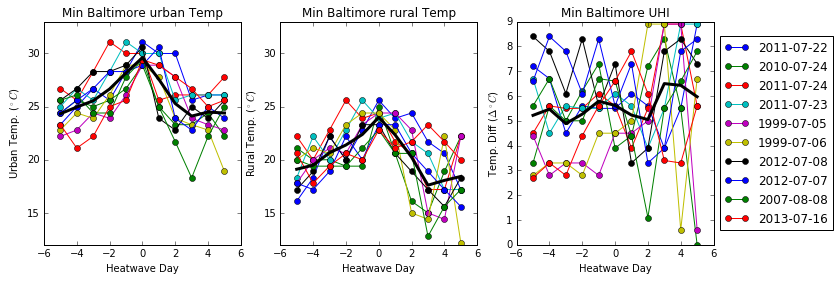

In [247]:
# overall hw composite baltimore with T(d)
temp = urban_summer#[urban_summer.index.year ==year]
x = rural_summer
y = urban_summer
x = x[y.dropna().index]
y = y[x.index]
ind = ~np.isnan(y) & ~np.isnan(x)

numhw = 50
final_num_hw = 10#50
#hw_ids = np.argsort(v[0])[(-1*final_num_hw):]
hw_ids = np.argsort(v[0])[0:final_num_hw]
hw_dates = x[ind].iloc[hw_ids].index
finalhw = rural_tmin[x[ind].iloc[hw_ids].index]
# Preallocate composite matrices to plot
compositeTemp = np.zeros([final_num_hw, 11])
compositeTemp2 = np.zeros([final_num_hw, 11])

compositeUHI = np.zeros([final_num_hw, 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeTemp2[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values

    #        compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,3,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
plt.title('Min %s urban Temp'%(city))
plt.ylabel('Urban Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.ylim([12, 33])

plt.subplot(1,3,2)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp2.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp2, axis=0), linewidth = 3, color = 'black')
plt.title('Min %s rural Temp'%(city))
plt.ylabel('Rural Temp. ($^\circ C$)')
plt.ylim([12, 33])
plt.xlabel('Heatwave Day')

plt.subplot(1,3,3)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
plt.title('Min %s UHI'%(city))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

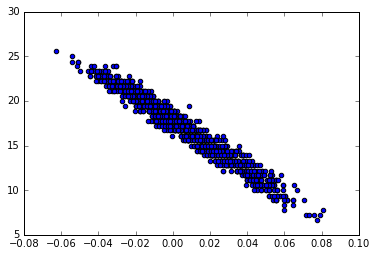

In [250]:
plt.scatter(v[0], x[ind])

In [225]:
finalhw.index

PeriodIndex(['1991-06-06', '1994-07-09', '1992-08-05', '1995-08-12',
             '1990-07-25', '2001-08-06', '1990-08-05', '1998-08-02',
             '2005-08-09', '1992-08-03'],
            dtype='period[D]', name=u'month_period', freq='D')

In [226]:
for date in finalhw.index
    

Period('1991-06-06', 'D')

In [217]:
for date in finalhw.index:
    urban_tmin[date]

KeyError: 7826

In [210]:
urban_tmin[dates.to_timestamp]

ValueError: Invalid frequency: month_period
1998-05-01    15.6
1998-05-02    14.4
1998-05-03    13.9
1998-05-04    16.1
1998-05-05    15.6
1998-05-06    15.6
1998-05-07    13.3
1998-05-08    15.0
1998-05-09    15.0
1998-05-10    13.3
1998-05-11    12.8
1998-05-12    11.7
1998-05-13    11.7
1998-05-14    11.1
1998-05-15    13.9
1998-05-16    20.6
1998-05-17    21.1
1998-05-18    20.0
1998-05-19    21.7
1998-05-20    23.3
1998-05-21    18.9
1998-05-22    15.0
1998-05-23    13.9
1998-05-24    14.4
1998-05-25    16.7
1998-05-26    20.6
1998-05-27    18.9
1998-05-28    16.1
1998-05-29    18.9
1998-05-30    21.7
              ... 
2017-01-30    -0.5
2017-01-31    -1.0
2017-02-01     3.9
2017-02-02     2.8
2017-02-03    -1.0
2017-02-04    -3.8
2017-02-05    -0.5
2017-02-06     2.8
2017-02-07     6.1
2017-02-08    11.1
2017-02-09    -3.2
2017-02-10    -4.3
2017-02-11     2.2
2017-02-12     6.7
2017-02-13     NaN
2017-02-14     NaN
2017-02-15     NaN
2017-02-16     NaN
2017-02-17     NaN
2017-02-18     NaN
2017-02-19     NaN
2017-02-20     NaN
2017-02-21     NaN
2017-02-22     NaN
2017-02-23     NaN
2017-02-24     NaN
2017-02-25     NaN
2017-02-26     NaN
2017-02-27     NaN
2017-02-28     NaN
Freq: D, Name: value, Length: 6879, dtype: float64

In [208]:
urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)]

Series([], Freq: D, Name: value, dtype: float64)

In [159]:
x.iloc[431]

7.7999999999999998

In [160]:
x.iloc[v[0].argmax():v[0].argmax()+1]

month_period
2003-06-02    7.8
Freq: D, Name: value, dtype: float64

In [170]:
rural_tmin.loc[date]

month_period
2003-06-02    7.8
Freq: D, Name: value, dtype: float64

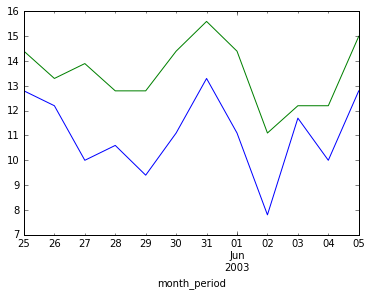

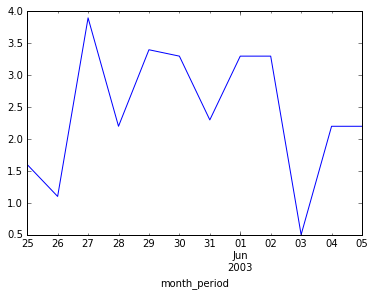

In [189]:
rural_tmin['2003-05-25': '2003-06-05'].plot()
urban_tmin['2003-05-25': '2003-06-05'].plot()

plt.figure()
urban_tmin['2003-05-25': '2003-06-05'].subtract(rural_tmin['2003-05-25': '2003-06-05']).plot()

AttributeError: 'tuple' object has no attribute 'get_figure'

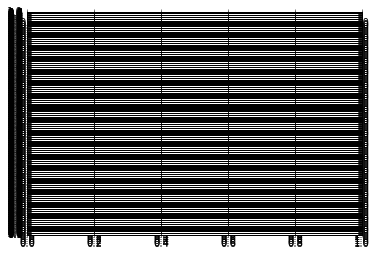

In [185]:
plt.figure()
ax = plt.subplots(121)
rural_tmin['2003-05-25': '2003-06-05'].plot(ax=ax)
urban_tmin['2003-05-25': '2003-06-05'].plot(ax=ax)
ax2 = plt.subplots(122)
urban_tmin['2003-05-25': '2003-06-05'].subtract(rural_tmin['2003-05-25': '2003-06-05']).plot(ax=ax2)

In [183]:
date

PeriodIndex(['2003-06-02'], dtype='period[D]', name=u'month_period', freq='D')

In [179]:
date = x.iloc[v[0].argmax():v[0].argmax()+1].index
rural_tmin.loc[date.to_timestamp()-pd.DateOffset(days=5): date.to_timestamp()+pd.DateOffset(days=5)]

TypeError: 'DatetimeIndex(['2003-05-28'], dtype='datetime64[ns]', name=u'month_period', freq=None)' is an invalid key

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds


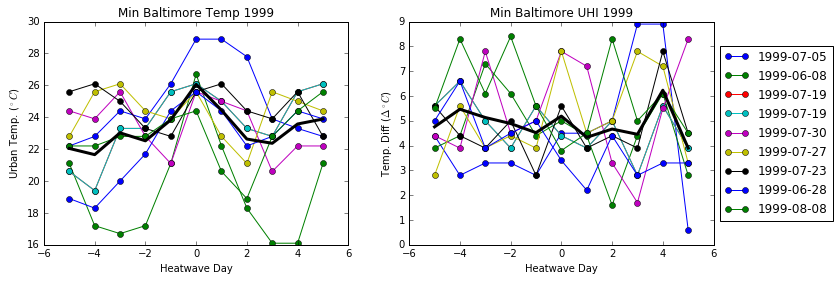

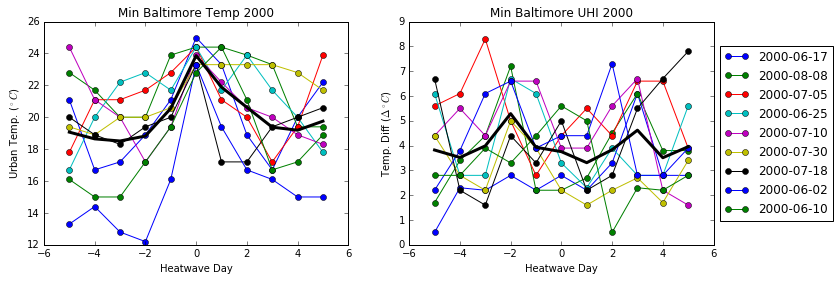

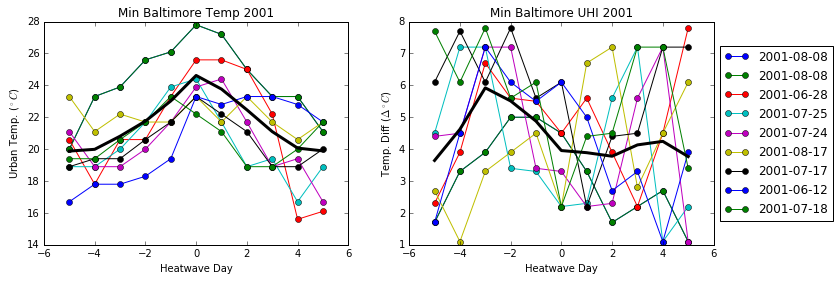

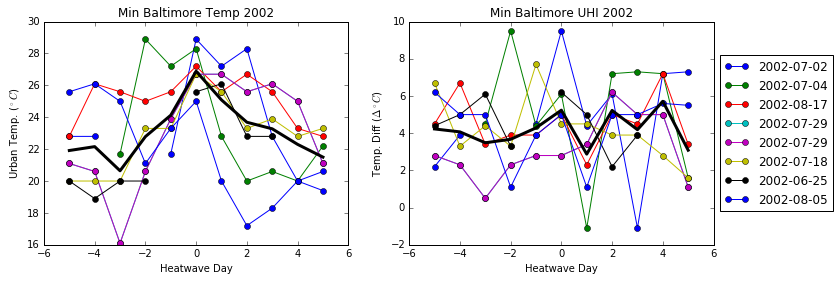

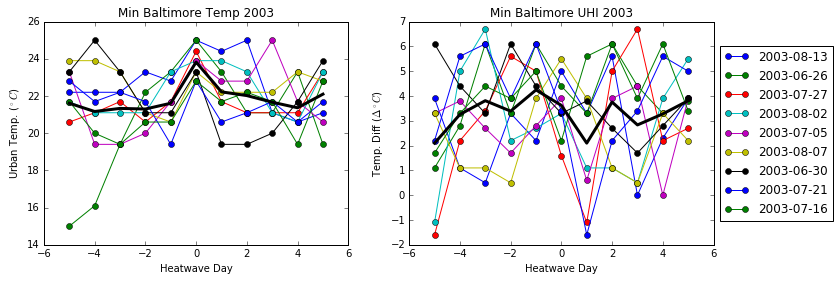

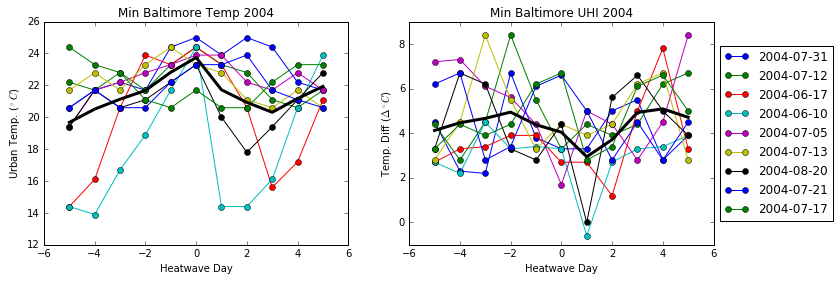

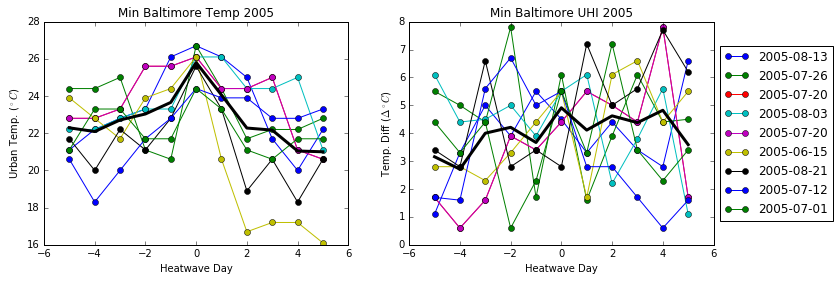

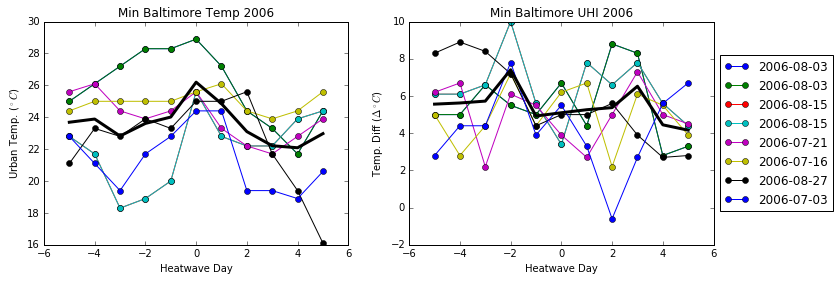

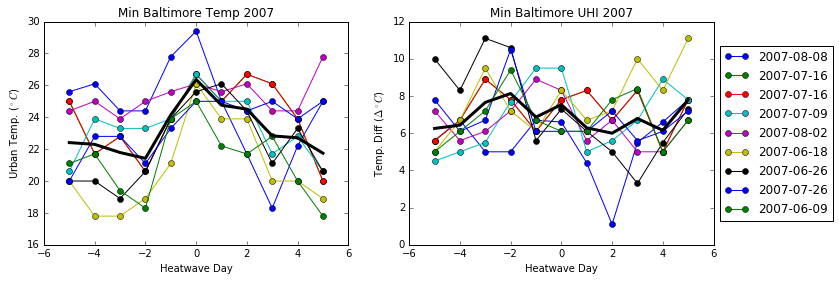

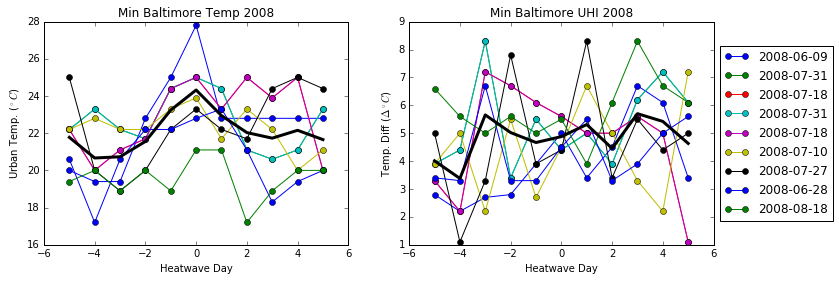

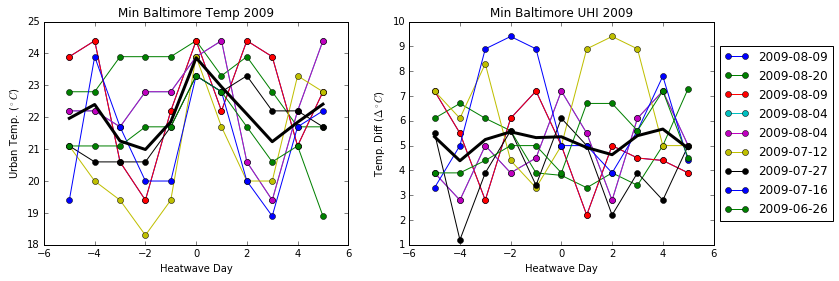

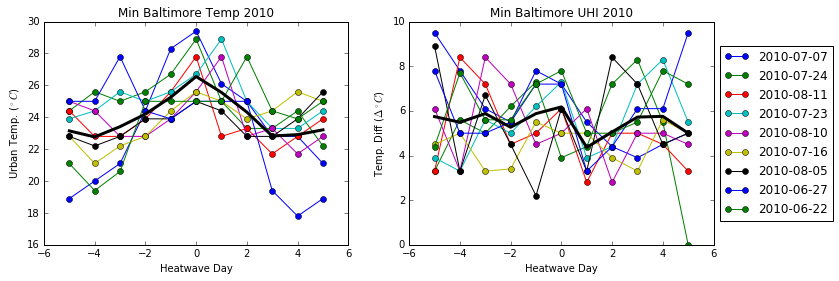

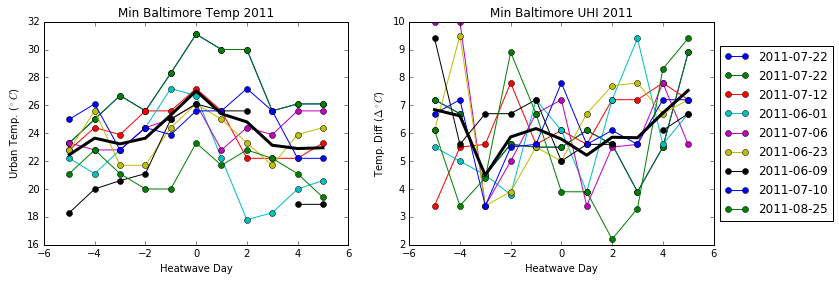

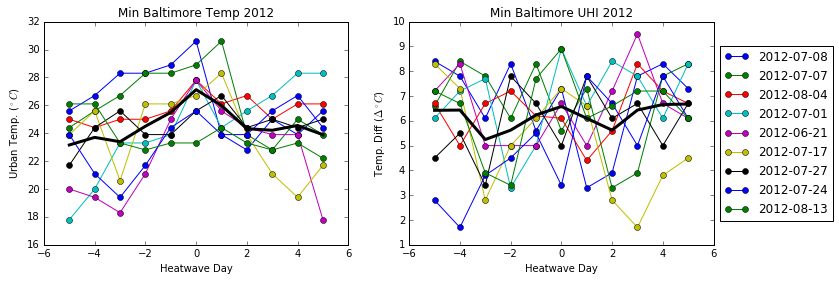

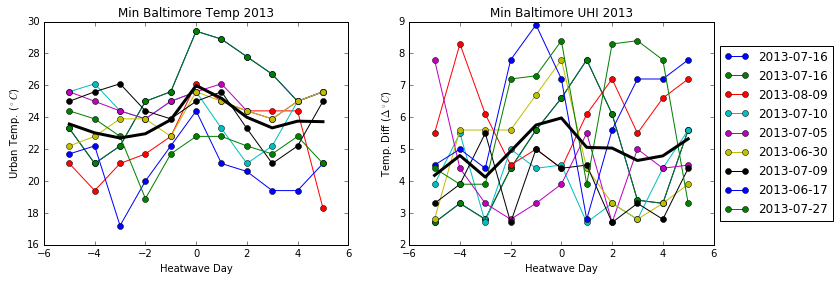

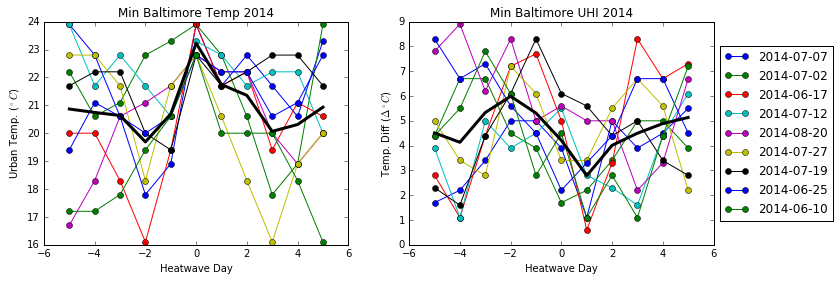

In [10]:
for year in range(1999, 2015): 
#    temp = rural_summer[rural_summer.index.year ==year]
    temp = urban_summer[urban_summer.index.year ==year]

    numhw = 50
    finalhw = 10#50

    hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
    minheatwaves = hottestmin[0:20]

    Ns = []
    m = 0 
    for n in range(1,10): 
        old = m
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            minheatwaves = hottestmin[0:55]
            try: 
                while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                print('out of bounds')
        try: 
            if old ==m : 
                Ns.append(minheatwaves.sort_index().index[m])
                #print(minheatwaves.sort_index().index[m])
            else: 
                Ns.append(minheatwaves.sort_index()[old:m].argmax())
                #print(minheatwaves.sort_index()[old:m].argmax())
        except: 
            'random error'
        m = m+1
    finalhw = hottestmin[Ns].sort_values(ascending=False)
    # Preallocate composite matrices to plot
    compositeTemp = np.zeros([finalhw.shape[0], 11])
    compositeUHI = np.zeros([finalhw.shape[0], 11])
    ii = 0
    for dates in finalhw.index[:]: 
        compositeTemp[ii,:]= urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
        #        compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
        compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
        ii = ii+1

    plt.figure(figsize=[12,4])
    plt.subplot(1,2,1)
    tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
    plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
    plt.title('Min %s Temp %i'%(city, year))
    plt.ylabel('Urban Temp. ($^\circ C$)')
    plt.xlabel('Heatwave Day')

    plt.subplot(1,2,2)    
    uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
    plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
    plt.title('Min %s UHI %i'%(city, year))
    plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
    plt.xlabel('Heatwave Day')
    plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


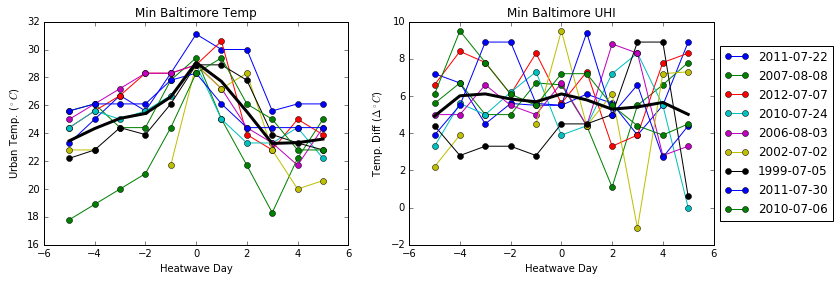

In [14]:
# overall hw composite baltimore with T_urban 
temp = urban_summer#[urban_summer.index.year ==year]

numhw = 50
finalhw = 10#50

hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:20]

Ns = []
m = 0 
for n in range(1,10): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:55]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
            #print(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
            #print(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)
# Preallocate composite matrices to plot
compositeTemp = np.zeros([finalhw.shape[0], 11])
compositeUHI = np.zeros([finalhw.shape[0], 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= urban_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    #        compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
plt.title('Min %s Temp'%(city))
plt.ylabel('Urban Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
plt.title('Min %s UHI'%(city))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

In [13]:
rural_tmax = pd.to_numeric(ruraldata['TMAX']['1985-01-01':].value/10.) #rural tmin
urban_tmax = pd.to_numeric(urbandata['TMAX']['1985-01-01':].value/10.) 

# extract summertime data 
rural_summer_max = rural_tmax[(rural_tmax.index.month >= 6) & (rural_tmax.index.month <= 8)]
urban_summer_max = urban_tmax[(urban_tmax.index.month >= 6) & (urban_tmax.index.month <= 8)]

#calculate UHI
UHI_max = urban_summer_max - rural_summer_max

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


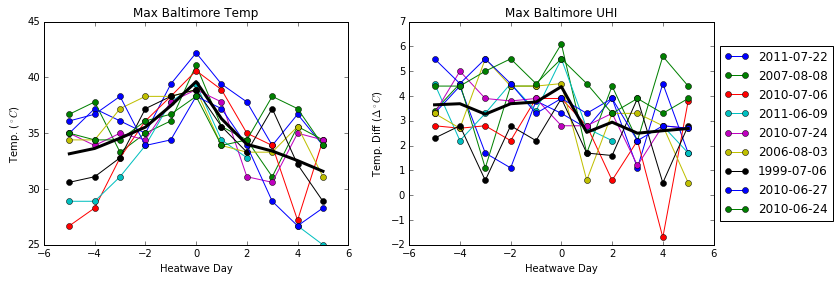

In [16]:
temp = urban_summer_max#[rural_summer_max.index.year ==year]
numhw = 50
finalhw = 10#50

#     minheatwaves = hottestmin[0:10]
#     hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 

#     Ns = []
#     m = 0 
#     for n in range(1,10): 
#         old = m
#         try: 
#             while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(2, 'D') : 
#                 m = m+1
#         except IndexError: 
#             minheatwaves = hottestmin[0:m+10]
#             while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(2, 'D') : 
#                 m = m+1
#         if old ==m : 
#             Ns.append(minheatwaves.sort_index().index[m])
#         else: 
#             Ns.append(minheatwaves.sort_index()[old:m].argmax())
#         m = m+1
#     finalhw = minheatwaves[Ns].sort_values(ascending=False)
hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:20]

Ns = []
m = 0 
for n in range(1,10): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:55]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# Preallocate composite matrices to plot
compositeTemp = np.zeros([finalhw.shape[0], 11])
compositeUHI = np.zeros([finalhw.shape[0], 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= urban_tmax[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmax-rural_tmax)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), label = 'mean', linewidth = 3, color = 'black')
plt.title('Max %s Temp'%(city))
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),  label = 'mean',  linewidth = 3,color = 'black')
plt.title('Max %s UHI'%(city))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')

out of bounds
out of bounds


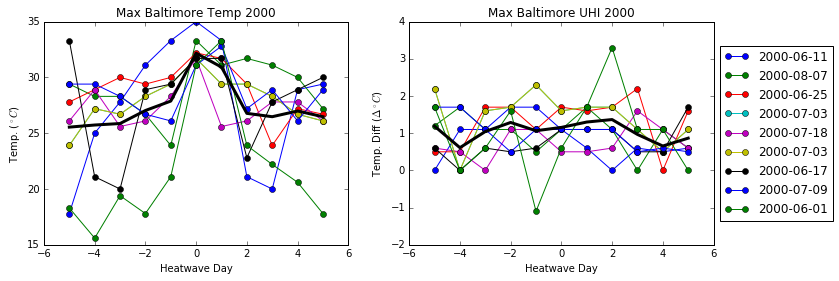

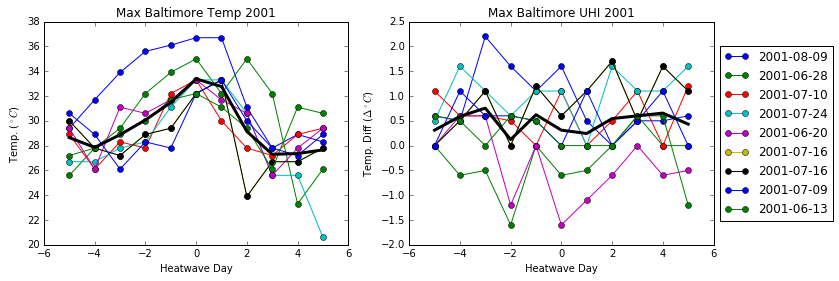

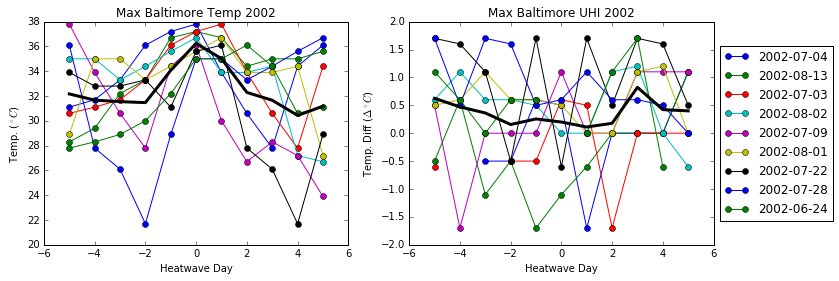

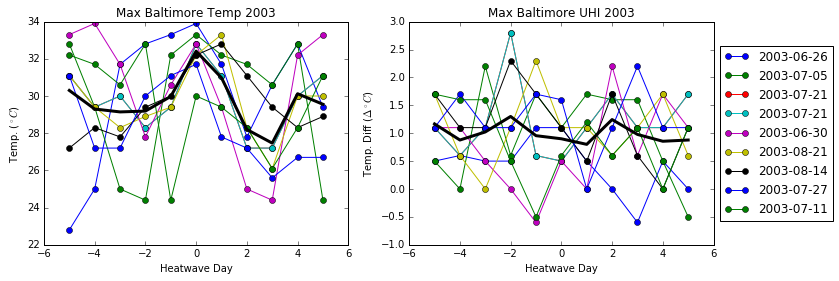

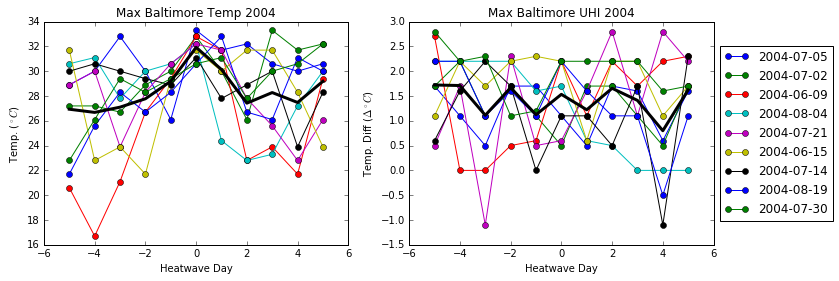

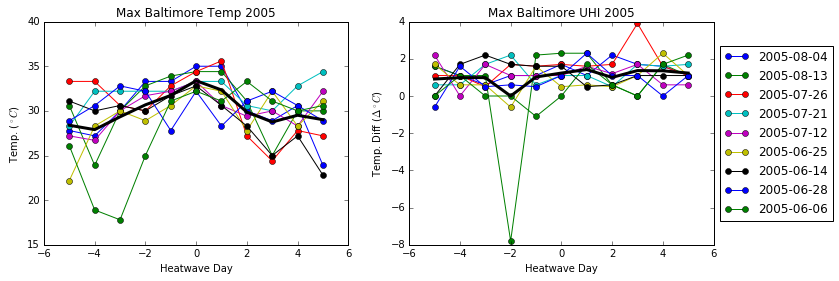

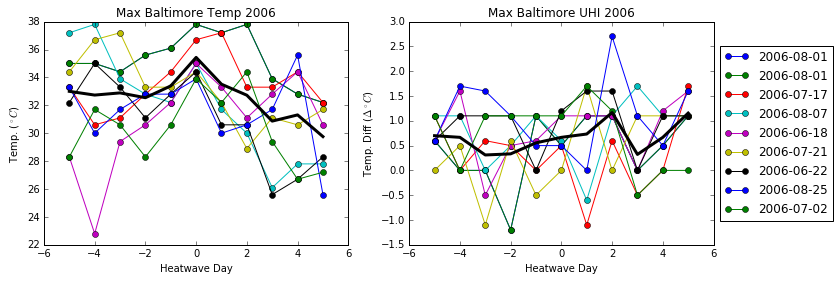

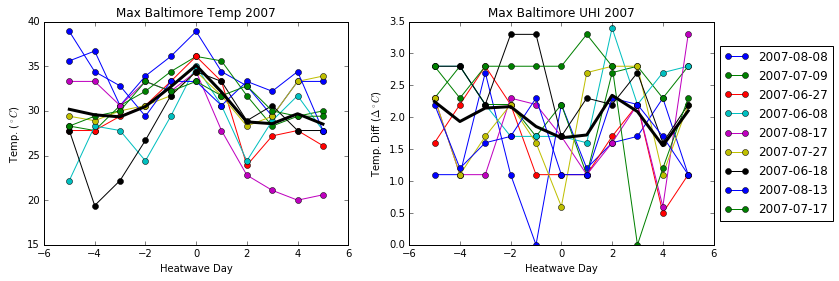

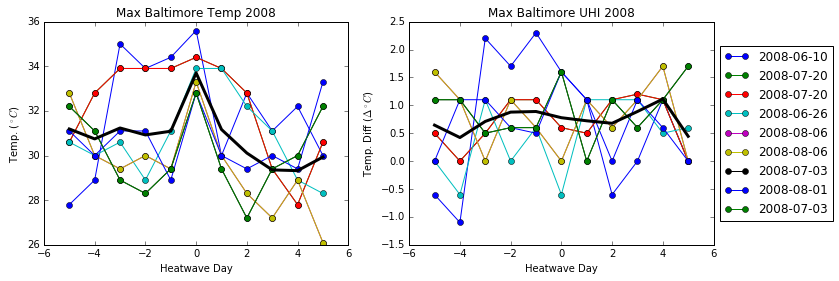

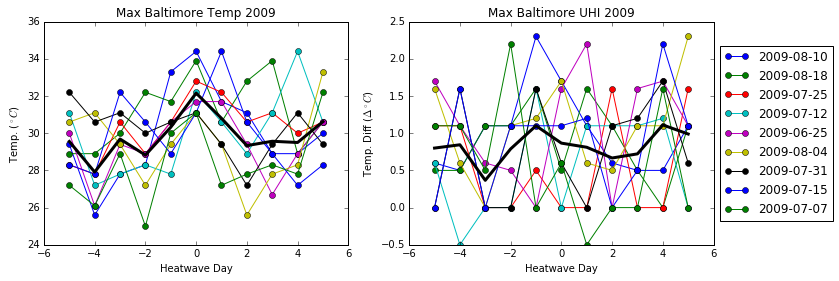

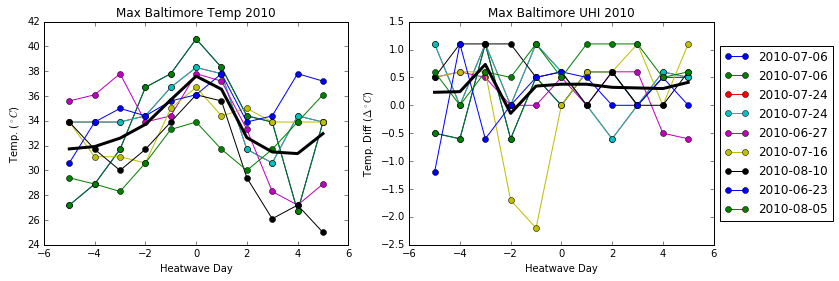

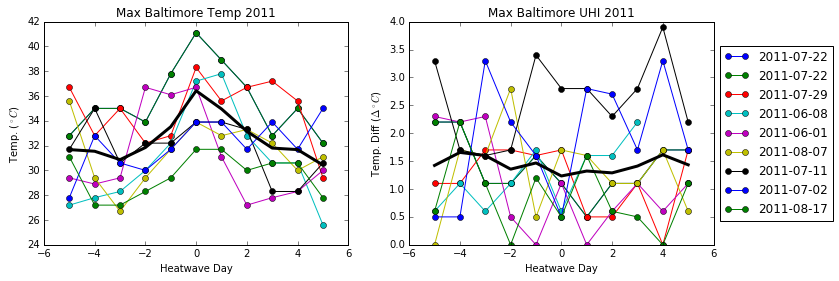

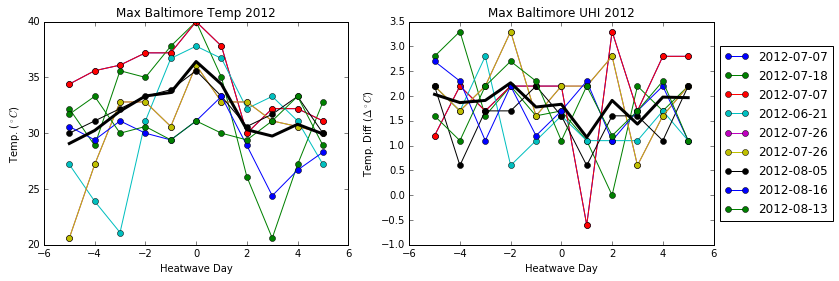

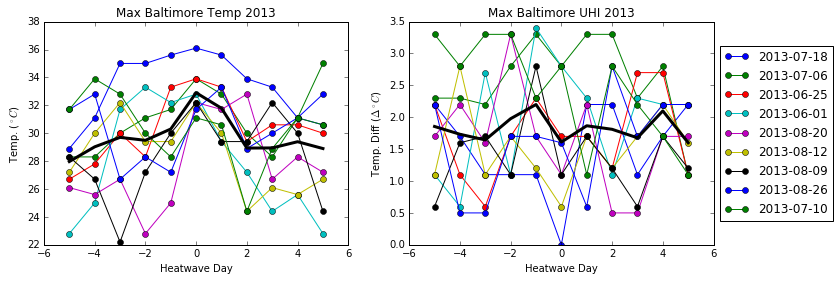

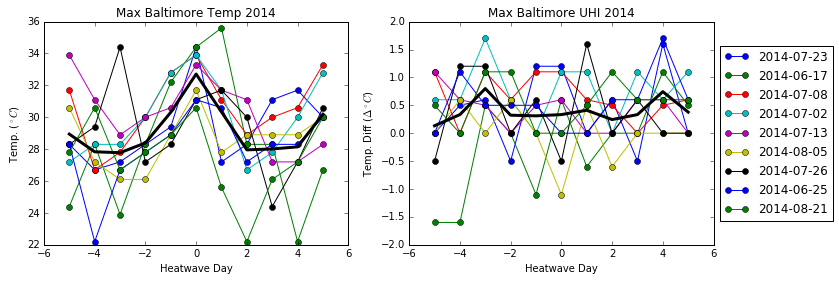

In [484]:
# do max analysis 
for year in range(2000, 2015): 
    temp = rural_summer_max[rural_summer_max.index.year ==year]
    numhw = 50
    finalhw = 10#50
    
#     minheatwaves = hottestmin[0:10]
#     hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
    
#     Ns = []
#     m = 0 
#     for n in range(1,10): 
#         old = m
#         try: 
#             while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(2, 'D') : 
#                 m = m+1
#         except IndexError: 
#             minheatwaves = hottestmin[0:m+10]
#             while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(2, 'D') : 
#                 m = m+1
#         if old ==m : 
#             Ns.append(minheatwaves.sort_index().index[m])
#         else: 
#             Ns.append(minheatwaves.sort_index()[old:m].argmax())
#         m = m+1
#     finalhw = minheatwaves[Ns].sort_values(ascending=False)
    hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
    minheatwaves = hottestmin[0:20]

    Ns = []
    m = 0 
    for n in range(1,10): 
        old = m
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            minheatwaves = hottestmin[0:55]
            try: 
                while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                print('out of bounds')
        try: 
            if old ==m : 
                Ns.append(minheatwaves.sort_index().index[m])
            else: 
                Ns.append(minheatwaves.sort_index()[old:m].argmax())
        except: 
            'random error'
        m = m+1
    finalhw = hottestmin[Ns].sort_values(ascending=False)

    # Preallocate composite matrices to plot
    compositeTemp = np.zeros([finalhw.shape[0], 11])
    compositeUHI = np.zeros([finalhw.shape[0], 11])
    ii = 0
    for dates in finalhw.index[:]: 
        compositeTemp[ii,:]= rural_tmax[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
        compositeUHI[ii,:] = (urban_tmax-rural_tmax)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
        ii = ii+1

    plt.figure(figsize=[12,4])
    plt.subplot(1,2,1)
    tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
    plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), label = 'mean', linewidth = 3, color = 'black')
    plt.title('Max %s Temp %i'%(city, year))
    plt.ylabel('Temp. ($^\circ C$)')
    plt.xlabel('Heatwave Day')

    plt.subplot(1,2,2)    
    uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
    plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
    plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),  label = 'mean',  linewidth = 3,color = 'black')
    plt.title('Max %s UHI %i'%(city, year))
    plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
    plt.xlabel('Heatwave Day')

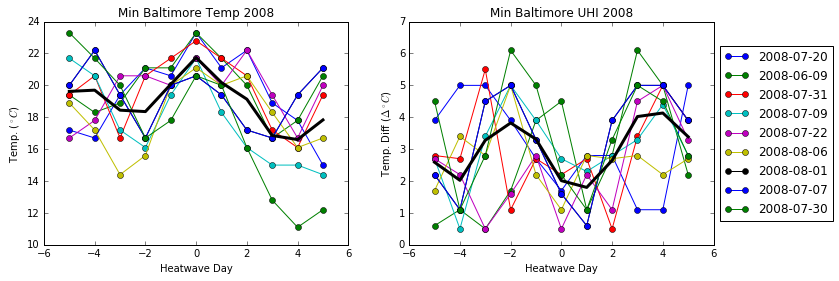

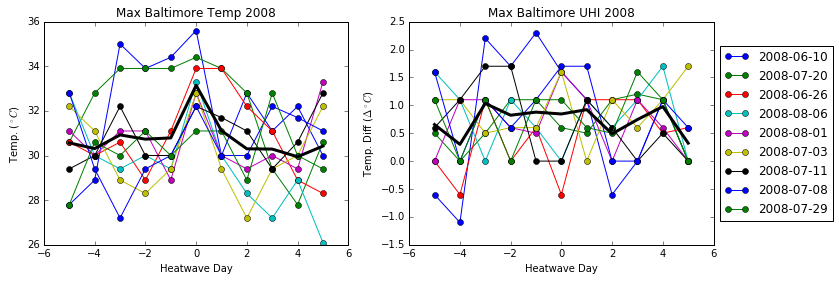

In [488]:
year = 2008

######Min 
temp = rural_summer[rural_summer.index.year ==year]

numhw = 50
finalhw = 10#50
hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:25]
Ns = []
m = 0 
for n in range(1,10): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:55]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
            #print(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
            #print(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# Preallocate composite matrices to plot
compositeTemp = np.zeros([finalhw.shape[0], 11])
compositeUHI = np.zeros([finalhw.shape[0], 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
plt.title('Min %s Temp %i'%(city, year))
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.legend(minheatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
plt.title('Min %s UHI %i'%(city, year))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')

##### Max 
temp = rural_summer_max[rural_summer_max.index.year ==year]
numhw = 50
finalhw = 10#50

hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:25]
Ns = []
m = 0 
for n in range(1,10): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:55]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
            #print(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
            #print(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# Preallocate composite matrices to plot
compositeTemp = np.zeros([finalhw.shape[0], 11])
compositeUHI = np.zeros([finalhw.shape[0], 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= rural_tmax[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmax-rural_tmax)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
plt.title('Max %s Temp %i'%(city, year))
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
plt.title('Max %s UHI %i'%(city, year))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')
#plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

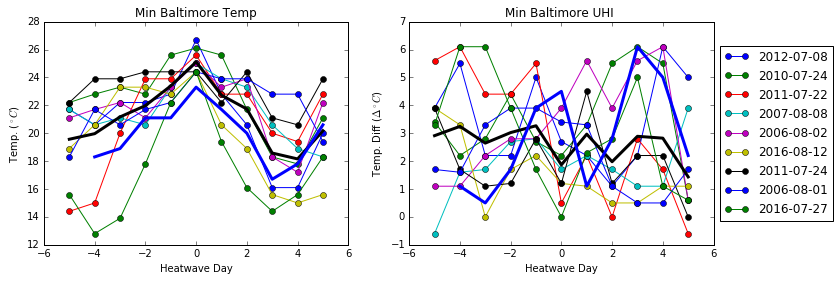

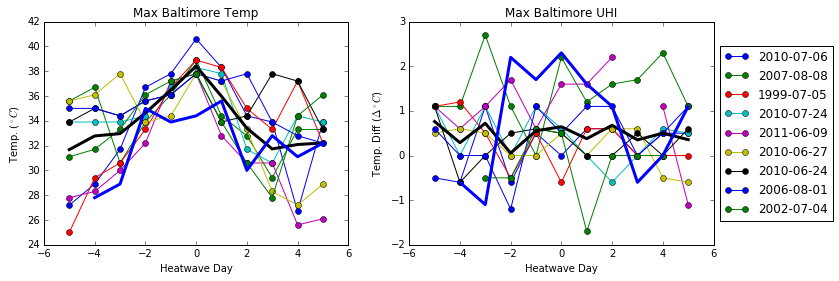

In [514]:
######Min 
year = 1998
temp = rural_summer[rural_summer.index.year> year]#[]

numhw = 50
finalhw = 10#50
hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:25]
Ns = []
m = 0 
for n in range(1,10): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:55]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
            #print(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
            #print(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# Preallocate composite matrices to plot
compositeTemp = np.zeros([finalhw.shape[0], 11])
compositeUHI = np.zeros([finalhw.shape[0], 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
plt.plot(np.arange(-4,6,1), rural_summer['2008-06-05':'2008-06-14'],  linewidth = 3, color = 'blue')

plt.title('Min %s Temp'%(city))
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.legend(minheatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
plt.plot(np.arange(-4,6,1), (urban_tmin-rural_tmin)['2008-06-05':'2008-06-14'], linewidth = 3, color = 'blue')

plt.title('Min %s UHI '%(city))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')

##### Max 
temp = rural_summer_max[rural_summer_max.index.year> year]
numhw = 50
finalhw = 10#50

hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:25]
Ns = []
m = 0 
for n in range(1,10): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:55]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
            #print(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
            #print(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# Preallocate composite matrices to plot
compositeTemp = np.zeros([finalhw.shape[0], 11])
compositeUHI = np.zeros([finalhw.shape[0], 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= rural_tmax[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmax-rural_tmax)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
plt.plot(np.arange(-4,6,1), rural_summer_max['2008-06-05':'2008-06-14'], linewidth = 3, color = 'blue')
plt.title('Max %s Temp'%(city))
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
plt.plot(np.arange(-4,6,1), (urban_tmax-rural_tmax)['2008-06-05':'2008-06-14'], linewidth = 3, color = 'blue')

plt.title('Max %s UHI'%(city))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')

The heatwave analyzed in Li \& Bou-Zeid et al takes place from June 5-14, 2008. This heatwave event was one of the warmer events for both $T_{max}$ and $T_{min}$ for 2008, though it is worth noting that 2008 was not a particularly hot year, and that the 2008 heatwave is not one of the 10 hottest heatwave events for the period 1999-2016 (when station data is available for similar stations). 

Furthermore, when we use stations identified by our pairing algorithm, 

In [517]:
pairs = pd.read_csv('CleanedNovUSpairs_stationlengths.csv').drop(2)

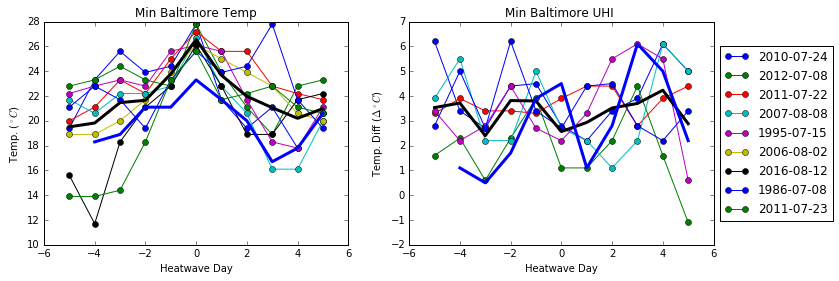

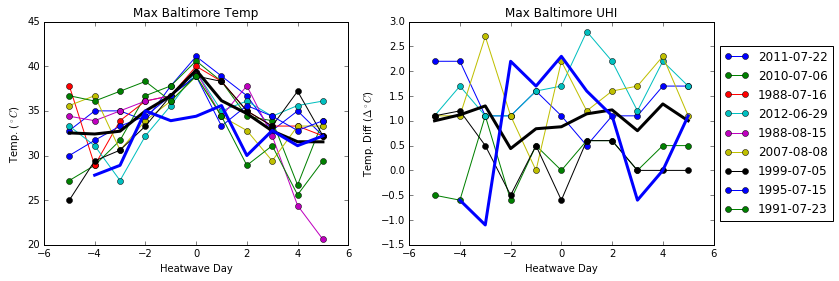

In [581]:
my_urban = pairs[pairs.City=='Baltimore']['Urban station']
my_rural = pairs[pairs.City=='Baltimore']['Rural station']

urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                 as_dataframe=True, update = False)
ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                 as_dataframe=True, update = False)

rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 

# extract summertime data 
rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

# clean data: eliminate min temperatures below 4 or above 35
rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

#calculate UHI
UHI = urban_summer - rural_summer

### tmax
rural_tmax = pd.to_numeric(ruraldata['TMAX']['1985-01-01':].value/10.) #rural tmin
urban_tmax = pd.to_numeric(urbandata['TMAX']['1985-01-01':].value/10.) 

# extract summertime data 
rural_summer_max = rural_tmax[(rural_tmax.index.month >= 6) & (rural_tmax.index.month <= 8)]
urban_summer_max = urban_tmax[(urban_tmax.index.month >= 6) & (urban_tmax.index.month <= 8)]

##### plot 
temp = rural_summer#[rural_summer.index.year> year]#[]

numhw = 50
finalhw = 10#50
hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:12]
Ns = []
m = 0 
for n in range(1,10): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:20]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
            #print(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
            #print(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# Preallocate composite matrices to plot
compositeTemp = np.zeros([finalhw.shape[0], 11])
compositeUHI = np.zeros([finalhw.shape[0], 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
plt.plot(np.arange(-4,6,1), rural_summer['2008-06-05':'2008-06-14'],  linewidth = 3, color = 'blue')

plt.title('Min %s Temp'%(city))
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.legend(minheatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
plt.plot(np.arange(-4,6,1), (urban_tmin-rural_tmin)['2008-06-05':'2008-06-14'], linewidth = 3, color = 'blue')

plt.title('Min %s UHI '%(city))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')

# ##### Max 
temp = rural_summer_max#[rural_summer_max.index.year> year]
numhw = 50
finalhw = 10#50

hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:12]
Ns = []
m = 0 
for n in range(1,10): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:20]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# Preallocate composite matrices to plot
compositeTemp = np.zeros([finalhw.shape[0], 11])
compositeUHI = np.zeros([finalhw.shape[0], 11])
ii = 0
for dates in finalhw.index[:]: 
    compositeTemp[ii,:]= rural_tmax[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmax-rural_tmax)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    ii = ii+1

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
plt.plot(np.arange(-4,6,1), rural_summer_max['2008-06-05':'2008-06-14'], linewidth = 3, color = 'blue')
plt.title('Max %s Temp'%(city))
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.legend(finalhw.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
plt.plot(np.arange(-4,6,1), (urban_tmax-rural_tmax)['2008-06-05':'2008-06-14'], linewidth = 3, color = 'blue')

plt.title('Max %s UHI'%(city))
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')

month_period
2011-07-22    41.1
2010-07-06    40.6
2012-07-18    40.0
1988-07-16    40.0
2012-07-07    40.0
1988-08-15    39.4
2012-06-29    39.4
2007-08-08    38.9
1995-07-15    38.9
1999-07-05    38.9
1991-07-23    38.9
2011-07-23    38.9
Freq: D, Name: value, dtype: float64